## Семинар 6 "Segmentation"

ФИО: __Иванов Иван Иванович__

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 ноября 2021). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc

from pathlib import Path

from PIL import Image
import skimage
from skimage import io


TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [128]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/")

In [42]:
import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)
dataset = Dataset(train_data,s_trans,t_trans)
dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=4)

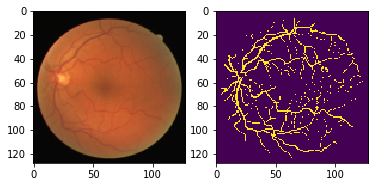

In [46]:
img,mask = dataset[12]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [48]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [ ]:
model = # Your model here

In [65]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [125]:
os.makedirs("result")
!zip -r result.zip result

(584, 565)

In [126]:
model = model.eval()
for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True).cuda()
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    scipy.misc.imsave("test/result/%s.png" % (ex_id + 1), tm)

/home/poisk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/poisk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # This is added back by InteractiveShellApp.init_path()


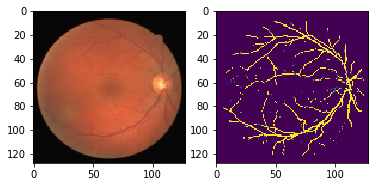

In [130]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)